# Sampling Over Waveform Uncertainty

In this tutorial, we demonstrate using this package to construct a prior of waveform uncertainty parameters and then using bilby to sample them. For more information, see [Equations and Notation](https://waveformuncertainty.readthedocs.io/en/latest/WFU_Equations.html) and [Likelihood Derivation](https://waveformuncertainty.readthedocs.io/en/latest/Likelihood_Equation.html). This notebook can be downloaded [here](https://github.com/RyanSR71/waveform_uncertainty/blob/main/docs/source/notebooks/WFU_Sampling_Tutorial.ipynb).

The following cell is everything we need to import to run this tutorial. We also import the `WaveformUncertainty` package, which will need to be installed first. See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [17]:
import os
import numpy as np
import bilby
import matplotlib.pyplot as plt
import lal
import pesummary
import scipy
from pesummary.gw.file.strain import StrainData
from pesummary.io import read
import requests
import WaveformUncertainty as wfu

## Setting Up the Prior

Here we set up a binary neutron star (BNS) prior with bilby.

In [3]:
prior = bilby.core.prior.PriorDict()

prior['chirp_mass'] = bilby.core.prior.Uniform(name='chirp_mass',latex_label=r'$\mathcal{M}$',minimum=1.195,maximum=1.20,unit=r'$\mathrm{M}_{\odot}$')
prior['mass_ratio'] = bilby.core.prior.Uniform(name='mass_ratio',latex_label=r'$q$',minimum=0.334,maximum=1.000)
prior['chi_1'] = bilby.core.prior.Uniform(name='chi_1',latex_label=r'$\chi_{1}$',minimum=-0.05, maximum=0.05)
prior['chi_2'] = bilby.core.prior.Uniform(name='chi_2',latex_label=r'$\chi_{2}$',minimum=-0.05, maximum=0.05)
prior['lambda_1'] = bilby.core.prior.Uniform(name="lambda_1",latex_label=r'$\Lambda_{1}$',minimum=0.01, maximum=5000.0)
prior['lambda_2'] = bilby.core.prior.Uniform(name="lambda_2",latex_label=r'$\Lambda_{2}$',minimum=0.01, maximum=5000.0)
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\phi$',minimum=0,maximum=6.2831853071795865,boundary='periodic')
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$\mathcal{L}_{D}$',minimum=1, maximum=100, unit='Mpc')
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time",latex_label=r'$t_{c}$',minimum=1187008882.3, maximum=1187008882.5,unit='s')
prior['phi_12'] = bilby.core.prior.Uniform(name='phi_12',latex_label=r'$\phi_{12}$',minimum=0,maximum=6.2831853071795865,boundary='periodic')
prior['phi_jl'] = bilby.core.prior.Uniform(name='phi_jl',latex_label=r'$\phi_{JL}$',minimum=0,maximum=6.2831853071795865,boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')
prior['psi'] = bilby.core.prior.DeltaFunction(name='psi',latex_label=r'$\psi$',peak=1.2695709169413083)
prior['ra'] = bilby.core.prior.DeltaFunction(name='ra',latex_label=r'$\alpha_{r}$',peak=3.44616)
prior['dec'] = bilby.core.prior.DeltaFunction(name='dec',latex_label=r'$\delta$',peak=-0.408084)

<br>

We then load in a set of parameterized waveform differences from which we will get our waveform uncertainties.

In [4]:
# downloading the file and saving to a folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/parameterization_nsamples_1000-4.npy', allow_redirects=True)
open("tutorial_files/parameterization_nsamples_1000.npy", 'wb').write(file.content)

# loading the file
parameterization = np.load("tutorial_files/parameterization_nsamples_1000.npy",allow_pickle=True)

# calculating the means and standard deviations of the waveform differences
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,phase_uncertainty,frequency_grid = wfu.uncertainties_from_parameterization(parameterization,linear=True,resolution=0.1)

<br>

Using the standard deviations of our waveform differences,  $\delta\mathcal{A}$ and $\delta\Phi$, and the means of our waveform differences, $\overline{\Delta\mathcal{A}}$ and $\overline{\Delta\Phi}$, we set up our prior distributions and add it to the previously defined prior.

In [5]:
# we also choose to use 6 geometrically spaced frequency nodes, as that configuration yields the best results
prior,frequency_nodes = wfu.WFU_prior(mean_amplitude_difference=mean_amplitude_difference,
                                     amplitude_uncertainty=amplitude_uncertainty,
                                     mean_phase_difference=mean_phase_difference,
                                     phase_uncertainty=phase_uncertainty,spacing='geometric',
                                     frequency_grid=frequency_grid,nnodes=6,prior=prior)

<br>

If we look at the prior, we confirm that the new parameters have been added properly:

In [6]:
prior

{'chirp_mass': Uniform(minimum=1.195, maximum=1.2, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$\\mathrm{M}_{\\odot}$', boundary=None),
 'mass_ratio': Uniform(minimum=0.334, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chi_1': Uniform(minimum=-0.05, maximum=0.05, name='chi_1', latex_label='$\\chi_{1}$', unit=None, boundary=None),
 'chi_2': Uniform(minimum=-0.05, maximum=0.05, name='chi_2', latex_label='$\\chi_{2}$', unit=None, boundary=None),
 'lambda_1': Uniform(minimum=0.01, maximum=5000.0, name='lambda_1', latex_label='$\\Lambda_{1}$', unit=None, boundary=None),
 'lambda_2': Uniform(minimum=0.01, maximum=5000.0, name='lambda_2', latex_label='$\\Lambda_{2}$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary='periodic'),
 'luminosity_distance': bilby.gw.prior.UniformSourceFrame(minimum=1.0, maximum=100.0, cosmology='Planck15', name='luminosity_distan

<br>

## Visualizing the Prior

Our model waveform uncertainty priors are defined as a normal distributions in amplitude and phase around $\overline{\Delta\mathcal{A}}$ and $\overline{\Delta\Phi}$ with standard deviations being our waveform uncertainties, $\delta\mathcal{A}$ and $\delta\Phi$. Each $\alpha$ and $\varphi$ parameter is a piece of the total distribution along its corresponding frequency node $f_{n}$. Here, we have 6 frequency nodes spaced geometrically, so we have 6 $\alpha$ parameters and 6 $\varphi$ parameters.

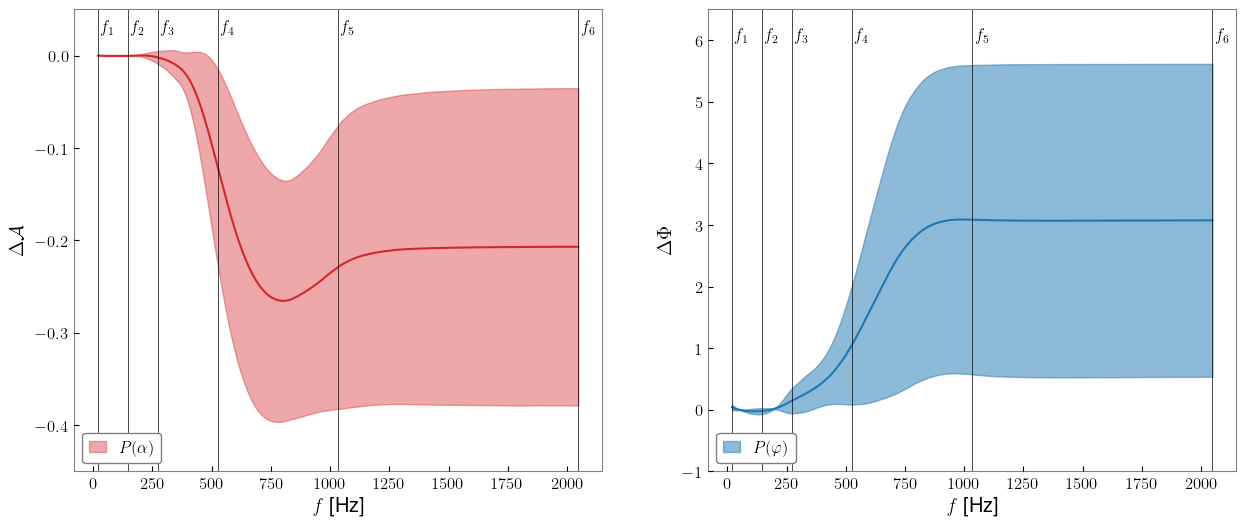

In [19]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the prior
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='tab:red',alpha=0.4,label=r'$P(\alpha)$',zorder=1)
ax[0].plot(frequency_grid,mean_amplitude_difference,color='tab:red')
# plotting the frequency nodes
for i in range(len(frequency_nodes)):
    ax[0].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[0].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,0.025))

ax[0].legend(fancybox=True,loc='lower left',framealpha=1)
ax[0].set_ylim(-0.45,0.05)
ax[0].grid(False)
ax[0].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[0].set_ylabel(r"$\Delta\mathcal{A}$")
ax[0].tick_params(direction='in')

# plotting the prior
ax[1].fill_between(frequency_grid,mean_phase_difference-phase_uncertainty,mean_phase_difference+phase_uncertainty,color='tab:blue',alpha=0.5,label=r'$P(\varphi)$',zorder=1)
ax[1].plot(frequency_grid,mean_phase_difference,color='tab:blue')
# plotting the frequency nodes
for i in range(len(frequency_nodes)):
    ax[1].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[1].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,6))

ax[1].legend(fancybox=True,loc='lower left',framealpha=1)
ax[1].set_ylim(-1,6.5)
ax[1].grid(False)
ax[1].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[1].set_ylabel(r"$\Delta\Phi$")
ax[1].tick_params(direction='in')

plt.show()

<br>

## Parameter Estimation Example

In this section, we will show how to use `WaveformUncertainty.WaveformGeneratorWFU` to perfom parameter estimation with and without the waveform uncertainty parameters.

For this example, we will set up two parameter estimation runs: one with the waveform uncertainty correction and one without. In [Posterior Analysis](https://waveformuncertainty.readthedocs.io/en/latest/notebooks/Posterior_Analysis_Tutorial.html), we can look at the differences between the result files and examine the effectiveness of the correction.

We start by defining an injection, which will remain fixed for both runs. For simplicity, we draw a purely random set of parameters from the prior.

In [9]:
PE_injection = prior.sample()
PE_injection

{'chirp_mass': 1.1969251815179687,
 'mass_ratio': 0.7296997048782708,
 'chi_1': 0.023305614892867185,
 'chi_2': 0.048347556946947076,
 'lambda_1': 354.449871571306,
 'lambda_2': 2361.7722256662764,
 'phase': 2.868564583935134,
 'luminosity_distance': 97.38750778082424,
 'geocent_time': 1187008882.3089032,
 'phi_12': 5.4176668413058175,
 'phi_jl': 3.4768638767535434,
 'theta_jn': 1.116756280245911,
 'psi': 1.2695709169413083,
 'ra': 3.44616,
 'dec': -0.408084,
 'alpha_1': -0.00048217182794752986,
 'alpha_2': 0.0002704185731702733,
 'alpha_3': 0.0022117456607715752,
 'alpha_4': -0.055413942286709136,
 'alpha_5': -0.0022819322139118747,
 'alpha_6': -0.08704212416432076,
 'phi_1': 0.12746362091614194,
 'phi_2': 0.017796957084130514,
 'phi_3': 0.1695248410592099,
 'phi_4': 0.15776162338532995,
 'phi_5': 2.596481890862608,
 'phi_6': 2.527797591512699}

Now we can set up the waveform generator that will supply the sampler with the injected waveform. We use [WaveformUncertainty.WaveformGeneratorWFU](https://waveformuncertainty.readthedocs.io/en/latest/WaveformGeneratorWFU.html) as our waveform generator function to incoporate the injected waveform uncertainty parameters into the waveform. We include the frequency_nodes and allow the sampler to use the amplitude and phase correction parameters, $\alpha$ and $\varphi$.

In [10]:
injected_waveform = wfu.WaveformGeneratorWFU(
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                waveform_arguments=dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, catch_waveform_errors=True, 
                                        f_low = 20.0, f_high=2048.0),
                frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star, 
                sampling_frequency=4096, 
                duration=256,
                # waveform uncertainty arguments
                waveform_uncertainty_nodes=frequency_nodes,
                dA_sampling=True,
                dphi_sampling=True,
            )

18:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


With the waveform generator set up, we set the interferometer objects with the injected signal, which will be the same for both runs.

In [12]:
# setting up interferometers
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=4096, duration=256,
    start_time=PE_injection['geocent_time'] - 2)
ifo_injection = ifos.inject_signal(
    waveform_generator=injected_waveform,
    parameters=PE_injection)

18:44 bilby INFO    : Injected signal in H1:
18:44 bilby INFO    :   optimal SNR = 15.19
18:44 bilby INFO    :   matched filter SNR = 14.03+0.62j
18:44 bilby INFO    :   chirp_mass = 1.1969251815179687
18:44 bilby INFO    :   mass_ratio = 0.7296997048782708
18:44 bilby INFO    :   chi_1 = 0.023305614892867185
18:44 bilby INFO    :   chi_2 = 0.048347556946947076
18:44 bilby INFO    :   lambda_1 = 354.449871571306
18:44 bilby INFO    :   lambda_2 = 2361.7722256662764
18:44 bilby INFO    :   phase = 2.868564583935134
18:44 bilby INFO    :   luminosity_distance = 97.38750778082424
18:44 bilby INFO    :   geocent_time = 1187008882.3089032
18:44 bilby INFO    :   phi_12 = 5.4176668413058175
18:44 bilby INFO    :   phi_jl = 3.4768638767535434
18:44 bilby INFO    :   theta_jn = 1.116756280245911
18:44 bilby INFO    :   psi = 1.2695709169413083
18:44 bilby INFO    :   ra = 3.44616
18:44 bilby INFO    :   dec = -0.408084
18:44 bilby INFO    :   alpha_1 = -0.00048217182794752986
18:44 bilby INFO 

Now we set up for the parameter estimation runs themselves. We start with the run that does not perform the waveform uncertainty correction.

We set up a new waveform generator object, which we will call "NHP_waveform". NHP represents "null-hypothesis", which means that this run assumes that there are no uncertainties. We often represent its likelihood with $\mathcal{L}_{\varnothing}(h|\theta)$, which does not include the $\alpha$ and $\varphi$ parameters. We use bilby's WaveformGenerator for this waveform.

In [13]:
NHP_waveform = bilby.gw.WaveformGenerator(
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                waveform_arguments=dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, catch_waveform_errors=True, 
                                        f_low = 20.0, f_high=2048.0),
                frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star, 
                sampling_frequency=4096, 
                duration=256,
            )

18:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Now we define the likelihood object and the sampler. Running the sampler will start the parameter estimation run, which will take days to complete, so it will not be run here.

In [14]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifos,
    NHP_waveform,
    priors=prior,
    time_marginalization=False, 
    phase_marginalization=False, 
    distance_marginalization=False,
)

In [ ]:
result = bilby.run_sampler(
    likelihood, prior, sampler='nestle', 
    label="NHP_result",
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    nlive=1000, 
    dlogz=1.,
    clean=True,
    maxiter=None,
)

With the null-hypothesis run complete, we now set up the waveform uncertainty correction run. We will call this new waveform generator "WFU_waveform", where WFU respresents "waveform uncertainty". The likelihood for this run is denoted with $\mathcal{L}(h|\theta,\alpha,\varphi)$. We need to use [WaveformUncertainty.WaveformGeneratorWFU](https://waveformuncertainty.readthedocs.io/en/latest/WaveformGeneratorWFU.html) as the waveform generator function to use the waveform uncertainty parameters.

In [15]:
WFU_waveform = wfu.WaveformGeneratorWFU(
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                waveform_arguments=dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, catch_waveform_errors=True, 
                                        f_low = 20.0, f_high=2048.0),
                frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star, 
                sampling_frequency=4096, 
                duration=256,
                waveform_uncertainty_nodes=frequency_nodes,
                dA_sampling=True,
                dphi_sampling=True,
            )

18:56 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


The steps of setting up the likelihood and sampler are repeated from the null-hypothesis run:

In [16]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifos,
    WFU_waveform,
    priors=prior,
    time_marginalization=False, 
    phase_marginalization=False, 
    distance_marginalization=False,
)

In [ ]:
result = bilby.run_sampler(
    likelihood, prior, sampler='nestle', 
    label="WFU_result",
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    nlive=1000, 
    dlogz=1.,
    clean=True,
    maxiter=None,
)

To see how analysis of the posteriors of these runs would be carried out, see [Posterior Analysis](https://waveformuncertainty.readthedocs.io/en/latest/notebooks/Posterior_Analysis_Tutorial.html).